In [845]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from utils.imputation import *
import re

In [746]:
family_start = pd.read_csv('../data/adj_family_start.csv')

In [747]:
family_start = family_start.rename(
    columns={'c1ylength': 'c1yheight', 'c2ylength': 'c2yheight', 'c3ylength': 'c3yheight'})

In [748]:
family_start = family_start.reset_index(drop=True)
family_start['id'] = family_start.index + 1


In [749]:
FS_time = family_start.drop(columns=['c0_3yBMIAUC', 'c0_5yBMIAUC', 'c5yBMIz_who'])
FS_time.shape

(997, 38)

In [750]:
df = FS_time

# Identify identifier and time-varying columns
identifier_cols = ['id']
time_varying_cols = [col for col in df.columns if col.startswith('c')]

# Rename columns to 'quantity_time' format
new_col_names = {}
pattern = re.compile(r'c(\d+)y(\w+)')

for col in time_varying_cols:
    match = pattern.match(col)
    if match:
        time = match.group(1)  # e.g., '25'
        quantity = match.group(2)  # e.g., 'height'
        new_col_names[col] = f"{quantity}_{time}"
    else:
        # If the column doesn't match the pattern, keep it as is
        new_col_names[col] = col

df_renamed = df.rename(columns=new_col_names)

#Use wide_to_long to reshape
stubnames = ['age', 'height', 'SBP', 'DBP', 'bmi']
df_long = pd.wide_to_long(df_renamed, stubnames=stubnames, i='id', j='time', sep='_', suffix='\d+')

# Reset index to flatten the DataFrame
df_long = df_long.reset_index()


In [752]:
FS_1 = df_long[df_long['time'] == 1]
FS_2 = df_long[df_long['time'] == 2]
FS_3 = df_long[df_long['time'] == 3]
FS_5 = df_long[df_long['time'] == 5]

In [753]:
statage = pd.read_csv('../data/statage.csv')

In [754]:
statage = statage[statage['Agemos'] < 61]
statage = statage.iloc[:, :5]
statage_male = statage[statage['Sex'] == 1]
statage_female = statage[statage['Sex'] == 2]


In [755]:
def heightZ(X, L, M, S):
    if L == 0:
        z = np.log(X / M) / S
    else:
        z = (((X / M) ** L) - 1) / (L * S)
    return z

def findHeightZ(data, growth_chart = statage_male):
    height = data["height"]

    target_value = data["age"]*12

    if data["csex"] == "2":
        growth_chart = statage_female

    closest_index = (growth_chart['Agemos'] - target_value).abs().idxmin()
    L = growth_chart.loc[closest_index, "L"]
    M = growth_chart.loc[closest_index, "M"]
    S =  growth_chart.loc[closest_index, "S"]

    return heightZ(height, L, M, S)


In [756]:
FS_5["Height Z-Score"] = FS_5.apply(findHeightZ, axis=1)

In [757]:
from utils.bpPercentile import *

def expectedSBP(data):
    age = data["age"]
    height_z = data["Height Z-Score"]

    if data["csex"] == "1":
        sex = "boy"
    else:
        sex = "girl"

    return calculate_expected_bp(age, height_z, sex)

def zscoreSBP(data):
    observed_sbp = data["SBP"]
    expected_sbp = data["Expected SBP"]

    if data["csex"] == "1":
        sex = "boy"
    else:
        sex = "girl"

    return calculate_bp_zscore(observed_sbp, expected_sbp, sex, measurement_type='sbp')

def percentileSBP(data):
    return calculate_bp_percentile(data["SBP Z Score"])


In [758]:
def expectedDBP(data):
    age = data["age"]
    height_z = data["Height Z-Score"]

    if data["csex"] == "1":
        sex = "boy"
    else:
        sex = "girl"

    return calculate_expected_bp(age, height_z, sex, measurement_type='dbp')

def zscoreDBP(data):
    observed_sbp = data["DBP"]
    expected_sbp = data["Expected DBP"]

    if data["csex"] == "1":
        sex = "boy"
    else:
        sex = "girl"

    return calculate_bp_zscore(observed_sbp, expected_sbp, sex, measurement_type='dbp')

def percentileDBP(data):
    return calculate_bp_percentile(data["DBP Z Score"])

In [762]:
FS_5["Expected SBP"] = FS_5.apply(expectedSBP, axis=1)
FS_5["SBP Z Score"] = FS_5.apply(zscoreSBP, axis=1)
FS_5["SBP Percentile"] = FS_5.apply(percentileSBP, axis=1)

In [763]:
FS_5["Expected DBP"] = FS_5.apply(expectedDBP, axis=1)
FS_5["DBP Z Score"] = FS_5.apply(zscoreDBP, axis=1)
FS_5["DBP Percentile"] = FS_5.apply(percentileDBP, axis=1)

In [764]:
FS_5.isnull().sum()

id                  0
time                0
Nethnic_mom         0
agemom              0
cbthweight          2
csex                0
everbfed            0
gdm_report          0
gestage             0
gestwgtgain        33
mblcvd              0
mblhdis             0
mblncig            30
mblsmkexp          25
msmkhist           30
ppbmi              16
ppwgt              12
priordiabp         38
stopbfed          138
age                 0
height              0
SBP                 0
DBP                 0
bmi                 0
Height Z-Score      0
Expected DBP        0
DBP Z Score         0
DBP Percentile      0
Expected SBP        0
SBP Z Score         0
SBP Percentile      0
dtype: int64

In [849]:
X_5 = FS_5.copy()
X_5 = FS_5.drop(columns=["id", "SBP", "DBP", "Height Z-Score", "Expected DBP", "DBP Z Score", "SBP Z Score", "SBP Percentile", "Expected SBP", "SBP Z Score", "time", "DBP Percentile"])


In [850]:
hypertension_threshold = 94.5

cond1 = FS_5["SBP Percentile"] > hypertension_threshold
cond2 = FS_5["DBP Percentile"] > hypertension_threshold
Y5 = (cond1 | cond2).astype(int)


### Convert columns to categorical

In [853]:
columns_to_encode = ['Nethnic_mom', 'csex','everbfed', 'gdm_report', 'mblcvd','mblhdis','msmkhist','priordiabp']
X_5[columns_to_encode] = X_5[columns_to_encode].astype('category')

In [854]:
X_5.to_csv("../data/X5yr.csv", index=False)
Y5.to_csv("../data/Y5yr.csv", index=False)

In [839]:
mice_imputer = MICEImputer(max_iter=5, random_state=42)
imputed_data = mice_imputer.fit_transform(X_5)

In [842]:
from sklearn.preprocessing import OneHotEncoder

XTEST = imputed_data.copy()
# List of columns to encode
columns_to_encode = ['Nethnic_mom', 'csex','everbfed', 'gdm_report', 'mblcvd','mblhdis','msmkhist','priordiabp']

# Initialize OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Fit and transform the specified columns
encoded_columns = encoder.fit_transform(XTEST[columns_to_encode])

# Get the new column names
ohe_columns = encoder.get_feature_names_out(columns_to_encode)

# Create a DataFrame with the encoded columns
encoded_df = pd.DataFrame(encoded_columns, columns=ohe_columns)

# Concatenate the original DataFrame with the encoded columns
resultTEST = pd.concat([XTEST.drop(columns=columns_to_encode), encoded_df], axis=1)
resultTEST

,agemom,cbthweight,gestage,gestwgtgain,mblncig,mblsmkexp,ppbmi,ppwgt,stopbfed,age,...,mblhdis_0.0,mblhdis_1.0,msmkhist_0.0,msmkhist_1.0,msmkhist_2.0,msmkhist_3.0,msmkhist_4.0,priordiabp_0.0,priordiabp_1.0,priordiabp_2.0
0,41.596167,2.855,38.000000,7.532843,0.00,0.0,31.108081,85.000000,10.100,5.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,35.819302,3.206,40.571429,13.154179,0.00,0.0,21.395656,54.431084,1.400,5.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,35.652293,2.970,37.571429,10.733578,0.00,0.0,19.407577,46.266422,10.600,5.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,32.624230,2.850,39.000000,10.152639,0.00,0.0,18.827111,47.000000,6.900,5.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,34.343600,3.792,41.000000,18.143695,0.00,0.0,21.717086,63.502932,9.293,5.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
992,24.000000,3.170,41.100000,4.000000,0.00,0.0,32.900000,81.000000,16.000,5.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
993,31.561944,3.575,41.142857,10.432625,7.64,0.0,34.536333,78.017888,0.200,5.9,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
994,18.592745,3.230,41.285714,19.607771,0.00,24.0,28.784723,82.992229,0.000,5.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
995,27.000000,4.325,41.300000,21.990000,0.00,0.0,21.200000,62.810000,9.491,5.2,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [813]:
# print("\nMissing values summary:")
# print(X_5.isnull().sum())
#
# # Perform imputation
# imputer = MixedTypeImputer()
# X5_imputed = imputer.fit_transform(X_5)
#
# print("\nMissing values after imputation:")
# print(X5_imputed.isnull().sum())


Missing values summary:
Nethnic_mom      0
agemom           0
cbthweight       2
csex             0
everbfed         0
gdm_report       0
gestage          0
gestwgtgain     33
mblcvd           0
mblhdis          0
mblncig         30
mblsmkexp       25
msmkhist        30
ppbmi           16
ppwgt           12
priordiabp      38
stopbfed       138
age              0
height           0
bmi              0
dtype: int64

Missing values after imputation:
Nethnic_mom    0
agemom         0
cbthweight     0
csex           0
everbfed       0
gdm_report     0
gestage        0
gestwgtgain    0
mblcvd         0
mblhdis        0
mblncig        0
mblsmkexp      0
msmkhist       0
ppbmi          0
ppwgt          0
priordiabp     0
stopbfed       0
age            0
height         0
bmi            0
dtype: int64


In [814]:
# from sklearn.preprocessing import OneHotEncoder
#
# X_encode = X5_imputed.copy()
# # List of columns to encode
# columns_to_encode = ['Nethnic_mom', 'csex','everbfed', 'gdm_report', 'mblcvd','mblhdis','msmkhist','priordiabp']
#
# # Initialize OneHotEncoder
# encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
#
# # Fit and transform the specified columns
# encoded_columns = encoder.fit_transform(X_encode[columns_to_encode])
#
# # Get the new column names
# ohe_columns = encoder.get_feature_names_out(columns_to_encode)
#
# # Create a DataFrame with the encoded columns
# encoded_df = pd.DataFrame(encoded_columns, columns=ohe_columns)
#
# # Concatenate the original DataFrame with the encoded columns
# result_df = pd.concat([X_encode.drop(columns=columns_to_encode), encoded_df], axis=1)
#
# print(result_df)

        agemom  cbthweight    gestage  gestwgtgain  mblncig  mblsmkexp  \
0    41.596167       2.855  38.000000     7.532843      0.0        0.0   
1    35.819302       3.206  40.571429    13.154179      0.0        0.0   
2    35.652293       2.970  37.571429    10.733578      0.0        0.0   
3    32.624230       2.850  39.000000    10.152639      0.0        0.0   
4    34.343600       3.792  41.000000    18.143695      0.0        0.0   
..         ...         ...        ...          ...      ...        ...   
992  24.000000       3.170  41.100000     4.000000      0.0        0.0   
993  31.561944       3.575  41.142857    10.432625      0.0        0.0   
994  18.592745       3.230  41.285714    19.607771      0.0       24.0   
995  27.000000       4.325  41.300000    21.990000      0.0        0.0   
996  29.000000       3.714  41.400000    17.500000      0.0        0.0   

         ppbmi      ppwgt  stopbfed  age  ...  mblhdis_0  mblhdis_1  \
0    31.108081  85.000000    10.100  5.0

Threshold: 0.1
Accuracy: 0.42
Confusion Matrix:
[[ 75 134]
 [ 11  30]]
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.36      0.51       209
           1       0.18      0.73      0.29        41

    accuracy                           0.42       250
   macro avg       0.53      0.55      0.40       250
weighted avg       0.76      0.42      0.47       250



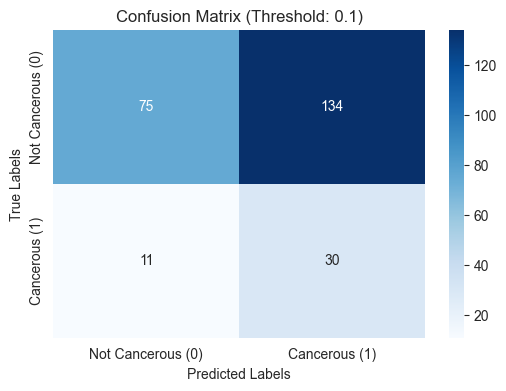

In [669]:
# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X5_imputed, Y, test_size=0.25, random_state=42)

# Step 3: Instantiate and train the logistic regression model
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

# Step 4: Function to evaluate model with different thresholds
def evaluate_model(threshold):
    # Get probabilities
    y_prob = logreg.predict_proba(X_test)[:, 1]
    # Apply threshold
    y_pred = (y_prob >= threshold).astype(int)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    print(f"Threshold: {threshold}")
    print(f"Accuracy: {accuracy}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(class_report)

    # Visualize confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Not Cancerous (0)', 'Cancerous (1)'],
                yticklabels=['Not Cancerous (0)', 'Cancerous (1)'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix (Threshold: {threshold})')
    plt.show()

# Step 5: Evaluate with different thresholds
thresholds = [0.1]
for threshold in thresholds:
    evaluate_model(threshold)



Class distribution after SMOTE: 0    631
1    631
Name: count, dtype: int64
Class distribution after undersampling: 0    631
1    631
Name: count, dtype: int64

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.96      0.89       209
           1       0.25      0.07      0.11        41

    accuracy                           0.81       250
   macro avg       0.55      0.52      0.50       250
weighted avg       0.74      0.81      0.77       250



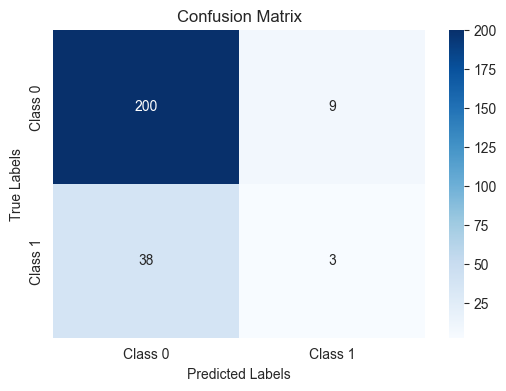

In [670]:
# Step 3: Apply SMOTE for oversampling the minority class
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train, y_train)

# Check the class distribution after SMOTE
print("Class distribution after SMOTE:", pd.Series(y_smote).value_counts())

# Step 4: Apply Random Undersampling to balance classes further (optional)
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_smote, y_smote)

# Check the class distribution after Random Undersampling
print("Class distribution after undersampling:", pd.Series(y_resampled).value_counts())

# Step 5: Train a classifier on the resampled data
clf = RandomForestClassifier(random_state=42, class_weight='balanced')
clf.fit(X_resampled, y_resampled)

# Step 6: Evaluate the model on the original test set (unchanged)
y_pred = clf.predict(X_test)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Step 7: Visualize the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

Classification Report (Adjusted Threshold):
              precision    recall  f1-score   support

           0       0.82      0.92      0.87       182
           1       0.68      0.47      0.56        68

    accuracy                           0.80       250
   macro avg       0.75      0.69      0.71       250
weighted avg       0.78      0.80      0.78       250



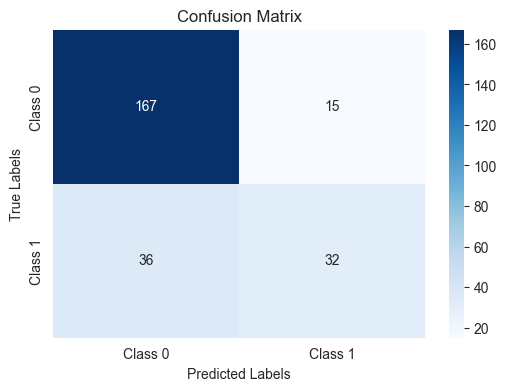

In [442]:
# Get predicted probabilities
y_prob = clf.predict_proba(X_test)[:, 1]

# Adjust threshold to 0.3
threshold = 0.5
y_pred_threshold = (y_prob >= threshold).astype(int)

# Evaluate with adjusted threshold
print("Classification Report (Adjusted Threshold):")
print(classification_report(y_test, y_pred_threshold))

conf_matrix = confusion_matrix(y_test, y_pred_threshold)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [671]:
from sklearn.preprocessing import OneHotEncoder

X_encode = X5_imputed.copy()
# List of columns to encode
columns_to_encode = ['Nethnic_mom', 'csex','everbfed', 'gdm_report', 'mblcvd','mblhdis','msmkhist','priordiabp']

# Initialize OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Fit and transform the specified columns
encoded_columns = encoder.fit_transform(X_encode[columns_to_encode])

# Get the new column names
ohe_columns = encoder.get_feature_names_out(columns_to_encode)

# Create a DataFrame with the encoded columns
encoded_df = pd.DataFrame(encoded_columns, columns=ohe_columns)

# Concatenate the original DataFrame with the encoded columns
result_df = pd.concat([X_encode.drop(columns=columns_to_encode), encoded_df], axis=1)

print(result_df)

        agemom  cbthweight    gestage  gestwgtgain  mblncig  mblsmkexp  \
0    41.596167       2.855  38.000000     7.532843      0.0        0.0   
1    35.819302       3.206  40.571429    13.154179      0.0        0.0   
2    35.652293       2.970  37.571429    10.733578      0.0        0.0   
3    32.624230       2.850  39.000000    10.152639      0.0        0.0   
4    34.343600       3.792  41.000000    18.143695      0.0        0.0   
..         ...         ...        ...          ...      ...        ...   
992  24.000000       3.170  41.100000     4.000000      0.0        0.0   
993  31.561944       3.575  41.142857    10.432625      0.0        0.0   
994  18.592745       3.230  41.285714    19.607771      0.0       24.0   
995  27.000000       4.325  41.300000    21.990000      0.0        0.0   
996  29.000000       3.714  41.400000    17.500000      0.0        0.0   

         ppbmi      ppwgt  stopbfed  age  ...  priordiabp_1.04  \
0    31.108081  85.000000    10.100  5.0  ...

In [672]:
X_encoded = result_df

Threshold: 0.3
Accuracy: 0.812
Confusion Matrix:
[[194  15]
 [ 32   9]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.93      0.89       209
           1       0.38      0.22      0.28        41

    accuracy                           0.81       250
   macro avg       0.62      0.57      0.58       250
weighted avg       0.78      0.81      0.79       250



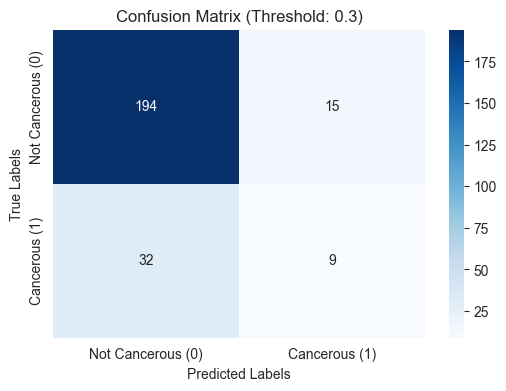

In [674]:
# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, Y, test_size=0.25, random_state=42)

# Step 3: Instantiate and train the logistic regression model
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

# Step 4: Function to evaluate model with different thresholds
def evaluate_model(threshold):
    # Get probabilities
    y_prob = logreg.predict_proba(X_test)[:, 1]
    # Apply threshold
    y_pred = (y_prob >= threshold).astype(int)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    print(f"Threshold: {threshold}")
    print(f"Accuracy: {accuracy}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(class_report)

    # Visualize confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Not Cancerous (0)', 'Cancerous (1)'],
                yticklabels=['Not Cancerous (0)', 'Cancerous (1)'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix (Threshold: {threshold})')
    plt.show()

# Step 5: Evaluate with different thresholds
thresholds = [0.3]
for threshold in thresholds:
    evaluate_model(threshold)


Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.99      0.91       840
           1       0.40      0.03      0.05       157

    accuracy                           0.84       997
   macro avg       0.62      0.51      0.48       997
weighted avg       0.77      0.84      0.78       997



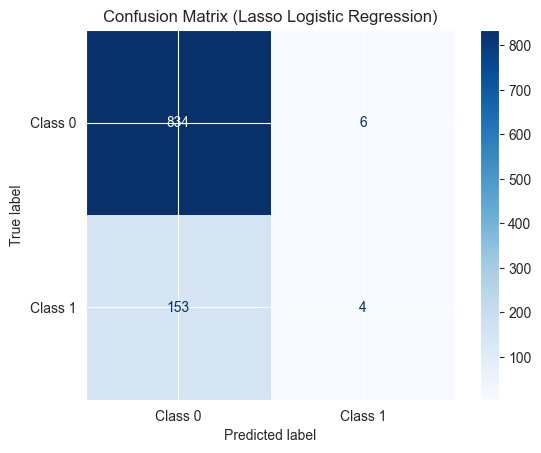

Model Coefficients:
 [ 0.17697754 -0.04347636 -0.05695308  0.02425235  0.12124495  0.09829749
  0.00257876  0.03430561  0.03848374 -0.0932786   0.09798353  0.03743163
 -0.3231643   0.48993438 -0.52347036  0.0244804  -0.11534787 -0.21988573
  0.15138407  0.31118395]


In [675]:
from sklearn.preprocessing import StandardScaler

# Step 2: Scale the features of the dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X5_imputed)

# Step 3: Train a Lasso Logistic Regression model using L1 penalty
lasso_log_reg = LogisticRegression(penalty='l1', solver='liblinear', C=1.0, random_state=42)
lasso_log_reg.fit(X_scaled, Y)

# Step 4: Evaluate the model's performance
y_pred = lasso_log_reg.predict(X_scaled)

# Classification report
report = classification_report(Y, y_pred)
print("Classification Report:\n", report)

# Confusion matrix
conf_matrix = confusion_matrix(Y, y_pred)
ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Class 0', 'Class 1']).plot(cmap='Blues')
plt.title('Confusion Matrix (Lasso Logistic Regression)')
plt.show()

# Step 5: Output the coefficients of the model
coefficients = lasso_log_reg.coef_[0]
print("Model Coefficients:\n", coefficients)


Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.95      0.88       730
           1       0.75      0.44      0.55       267

    accuracy                           0.81       997
   macro avg       0.79      0.69      0.72       997
weighted avg       0.80      0.81      0.79       997


True Positive Rate (TPR): 0.44
True Negative Rate (TNR): 0.95


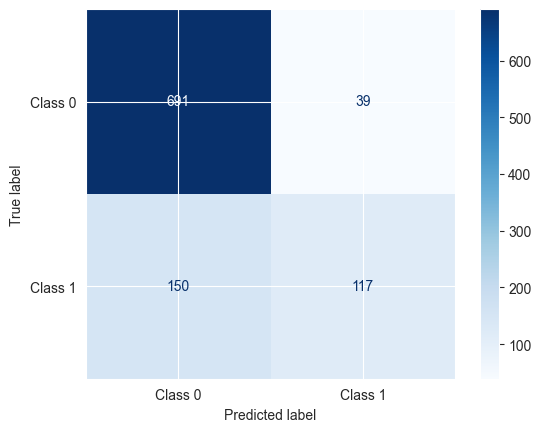

In [463]:
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

y = Y

# Step 2: Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X5_imputed)

# Step 3: Perform Lasso Logistic Regression with Cross-Validation
lasso_log_reg_cv = LogisticRegressionCV(
    penalty="l1",
    solver="liblinear",
    cv=5,
    scoring="accuracy",  # Use accuracy as the default scoring metric
    random_state=42,
)
lasso_log_reg_cv.fit(X_scaled, y)

# Step 4: Use cross_val_predict to get predictions for each fold
cv = StratifiedKFold(n_splits=5)
y_pred = cross_val_predict(lasso_log_reg_cv, X_scaled, y, cv=cv)

# Step 5: Evaluate the model using a confusion matrix and classification report
conf_matrix = confusion_matrix(y, y_pred)
ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Class 0", "Class 1"]).plot(cmap="Blues")
print("\nClassification Report:")
print(classification_report(y, y_pred))

# Step 6: Calculate True Positive and True Negative Rates for each fold
tn, fp, fn, tp = conf_matrix.ravel()
true_positive_rate = tp / (tp + fn)
true_negative_rate = tn / (tn + fp)

print(f"\nTrue Positive Rate (TPR): {true_positive_rate:.2f}")
print(f"True Negative Rate (TNR): {true_negative_rate:.2f}")

Threshold: 0.05, True Positive Rate (TPR): 1.000
Threshold: 0.10, True Positive Rate (TPR): 0.992
Threshold: 0.15, True Positive Rate (TPR): 0.988
Threshold: 0.20, True Positive Rate (TPR): 0.977
Threshold: 0.25, True Positive Rate (TPR): 0.953
Threshold: 0.30, True Positive Rate (TPR): 0.915
Threshold: 0.35, True Positive Rate (TPR): 0.860
Threshold: 0.40, True Positive Rate (TPR): 0.810
Threshold: 0.45, True Positive Rate (TPR): 0.748
Threshold: 0.50, True Positive Rate (TPR): 0.698
Threshold: 0.55, True Positive Rate (TPR): 0.640
Threshold: 0.60, True Positive Rate (TPR): 0.554
Threshold: 0.65, True Positive Rate (TPR): 0.434
Threshold: 0.70, True Positive Rate (TPR): 0.345
Threshold: 0.75, True Positive Rate (TPR): 0.256
Threshold: 0.80, True Positive Rate (TPR): 0.190
Threshold: 0.85, True Positive Rate (TPR): 0.116


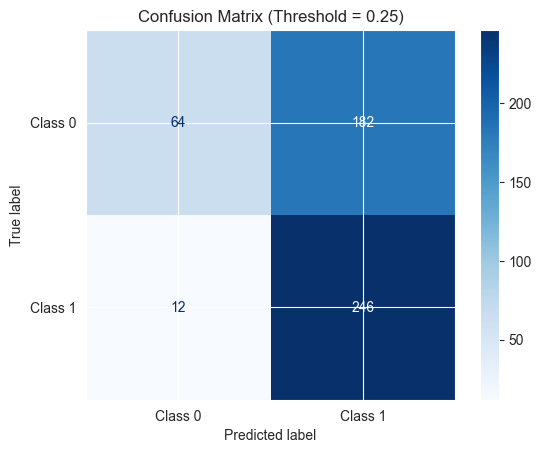


Classification Report (Optimal Threshold):
               precision    recall  f1-score   support

           0       0.84      0.26      0.40       246
           1       0.57      0.95      0.72       258

    accuracy                           0.62       504
   macro avg       0.71      0.61      0.56       504
weighted avg       0.71      0.62      0.56       504



In [721]:

y = Y
X_BTsmote, y_BTsmote = smote.fit_resample(X_encoded, y)
# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_BTsmote, y_BTsmote, test_size=0.3, random_state=42)

# Step 3: Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 4: Train a logistic regression model
log_reg = LogisticRegression(solver="liblinear", random_state=42)
log_reg.fit(X_train_scaled, y_train)

# Step 5: Adjust the decision threshold to optimize for TPR
y_prob = log_reg.predict_proba(X_test_scaled)[:, 1]

# Experiment with different thresholds to maximize TPR
thresholds = np.arange(0.05, 0.9, 0.05)
for threshold in thresholds:
    y_pred_threshold = (y_prob >= threshold).astype(int)
    conf_matrix = confusion_matrix(y_test, y_pred_threshold)
    tn, fp, fn, tp = conf_matrix.ravel()
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # True Positive Rate
    print(f"Threshold: {threshold:.2f}, True Positive Rate (TPR): {tpr:.3f}")

# Choose a specific threshold (e.g., 0.3) based on results
optimal_threshold = 0.25
y_pred_optimal = (y_prob >= optimal_threshold).astype(int)

# Step 6: Evaluate the model's performance with the chosen threshold
conf_matrix_optimal = confusion_matrix(y_test, y_pred_optimal)
ConfusionMatrixDisplay(confusion_matrix=conf_matrix_optimal, display_labels=["Class 0", "Class 1"]).plot(cmap="Blues")
plt.title(f"Confusion Matrix (Threshold = {optimal_threshold})")
plt.show()

# Classification report for the chosen threshold
class_report_optimal = classification_report(y_test, y_pred_optimal)
print("\nClassification Report (Optimal Threshold):\n", class_report_optimal)

ROC AUC Score: 0.95


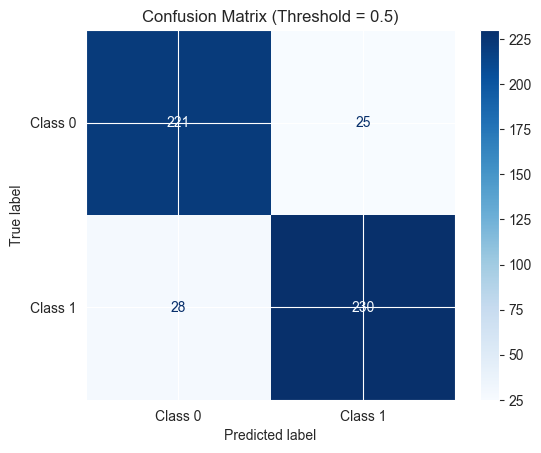


True Positive Rate (TPR): 0.89
True Negative Rate (TNR): 0.90


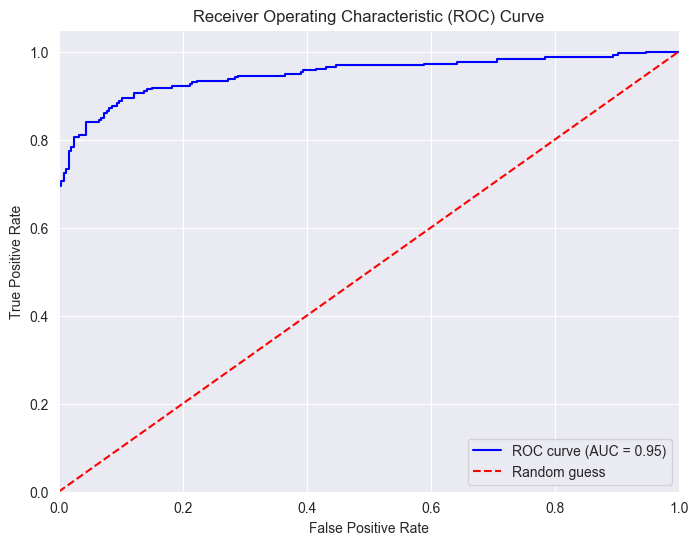

In [843]:
from sklearn.metrics import roc_auc_score, roc_curve
from xgboost import XGBClassifier
y = Y

#X_BTsmote, y_BTsmote = smote.fit_resample(X_encoded, y)
X_BTsmote, y_BTsmote = smote.fit_resample(resultTEST, y)
# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_BTsmote, y_BTsmote, test_size=0.3, random_state=42)

# Step 3: Initialize and train the XGBoost classifier
model = XGBClassifier(
    n_estimators=50,
    learning_rate=0.45,
    max_depth=10,
    random_state=42,
    use_label_encoder=False,
    eval_metric='auc'
)
model.fit(X_train, y_train)

# Step 4: Make probability predictions on the test set
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

# Step 5: Calculate the ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC Score: {roc_auc:.2f}")

# Adjust threshold
new_threshold = 0.50
y_pred_new = (y_pred_proba >= new_threshold).astype(int)

# Recalculate confusion matrix
conf_matrix_new = confusion_matrix(y_test, y_pred_new)

# Visualize new confusion matrix
ConfusionMatrixDisplay(confusion_matrix=conf_matrix_new, display_labels=["Class 0", "Class 1"]).plot(cmap="Blues")
plt.title(f"Confusion Matrix (Threshold = {new_threshold})")
plt.show()

# Step 6: Calculate True Positive and True Negative Rates for each fold
tn, fp, fn, tp = conf_matrix_new.ravel()
true_positive_rate = tp / (tp + fn)
true_negative_rate = tn / (tn + fp)

print(f"\nTrue Positive Rate (TPR): {true_positive_rate:.2f}")
print(f"True Negative Rate (TNR): {true_negative_rate:.2f}")

# Step 6: Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()